In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft
from scipy import signal
import math
from acoustics.cepstrum import complex_cepstrum
from acoustics.cepstrum import inverse_complex_cepstrum
from scipy.spatial import distance

In [2]:
#Func gives real and imag of FFT provide dataframe in Time Domain
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data1 = pd.DataFrame(zip(f,yf.real),columns=['Freq','Ampli'])
    fft_data2 = pd.DataFrame(zip(f,yf.imag),columns=['Freq','Ampli'])
    return fft_data1,fft_data2

In [3]:
def idft2(yr, yi):
    N, x = yr.shape[0], []
    yr = dict(yr.values)
    yi = dict(yi.values)
    for t in range(N):
        real = 0
        for (k,v),(k2,v2) in zip(yr.items(),yi.items()):
            theta1 = t * (2 * math.pi) * k
            theta2 = t * (2 * math.pi) * k2
            real += (v * math.cos(theta1)) - (v2 * math.sin(theta2))
        x.append(real/N)
    return x

In [4]:
def log_freq(df1, df2):
    df1['Ampli'] = np.log(df1["Ampli"])
    df1['Ampli'] = df1['Ampli'].replace([np.inf, -np.inf], 0)
    df1 = df1.fillna(0)
    df2['Ampli'] = np.log(df2["Ampli"])
    df2['Ampli'] = df2['Ampli'].replace([np.inf, -np.inf], 0)
    df2 = df2.fillna(0)
    return df1, df2

In [5]:
#Func gives magnitude of FFT provide dataframe in Time Domain
def freq_mag(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(f,np.abs(yf)),columns=['Freq','Ampli'])
    return fft_data

In [6]:
def freq_phase(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data1 = pd.DataFrame(zip(f,np.angle(yf)),columns=['Freq','Phase'])
    return fft_data1

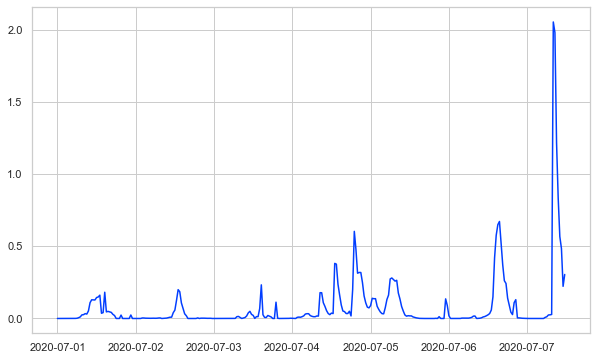

In [11]:
df = pd.read_csv(r"C:\Users\admin\Documents\Algo Asylum\Precipitation_Analysis\preci_all.csv")
df.columns = ['Date','ddate','value','geo']
df['Date'] = df['Date'].astype(str).str[:-2].astype(str)
df['Date'].iloc[43]
df.columns
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d%H%M')
del df['ddate'],df['geo']
#plt.show()
sd = df.loc[(df['Date'].between('2020-07-01 00:00:00', '2020-07-07 11:30:00', inclusive=True))]
#sd['Date'] = pd.to_datetime(sd['Date'])
#y['date'] = y.groupby(y['date'].dt.date).sum()
#sd = sd.iloc[:, 1:]
s = sd['value']
t = sd['Date']
plt.figure(figsize=(10,6))
plt.plot(t, s)
#plt.title("Data")

In [12]:
tf1 = np.arange(s.shape[0])
signal_1 = pd.DataFrame(zip(tf1,s),columns=['Time','Value'])

(array([281.,  18.,   7.,   2.,   1.,   1.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.20544811, 0.41089623, 0.61634434, 0.82179245,
        1.02724056, 1.23268868, 1.43813679, 1.6435849 , 1.84903302,
        2.05448113]),
 <BarContainer object of 10 artists>)

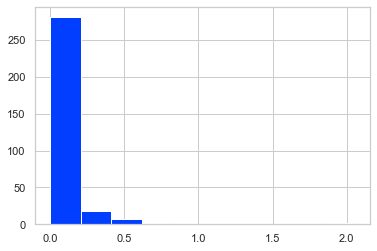

In [13]:
plt.hist(signal_1['Value'])

## Freq on Real and Imag

<StemContainer object of 3 artists>

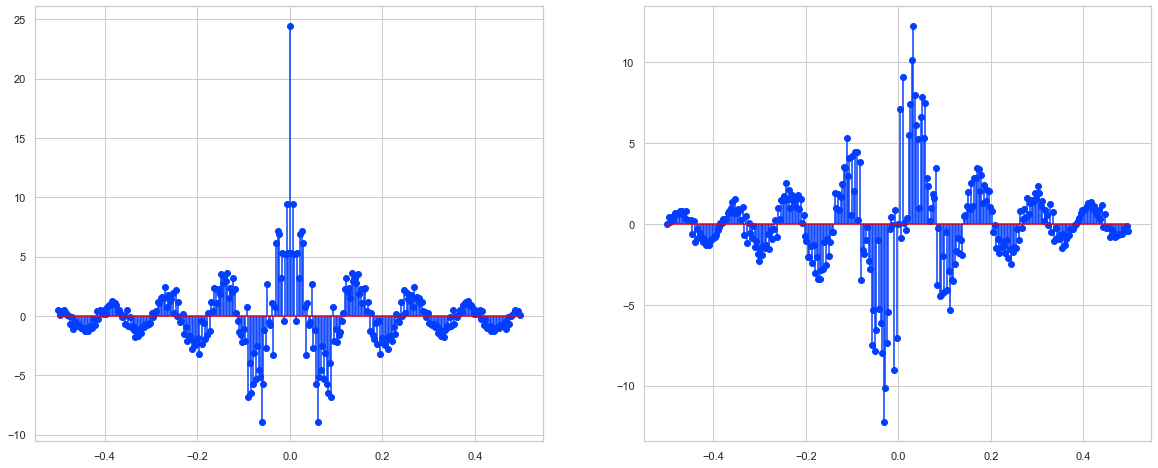

In [14]:
freq_ampli1,freq_ampli1i = freq(signal_1)
fig, axs = plt.subplots(1,2,figsize=(20,8))
axs[0].stem(freq_ampli1['Freq'], freq_ampli1['Ampli'])
axs[1].stem(freq_ampli1i['Freq'], freq_ampli1i['Ampli'])

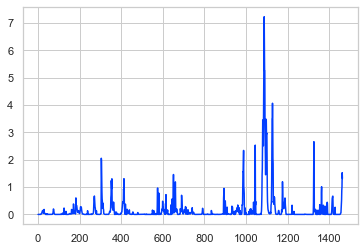

In [30]:
value = idft2(freq_ampli1,freq_ampli1i)
plt.plot(value)

In [31]:
distance.euclidean(signal_1["Value"],value)

8.285340899709537e-13

## Log Freq

In [32]:
log1, log1i = log_freq(freq_ampli1, freq_ampli1i)

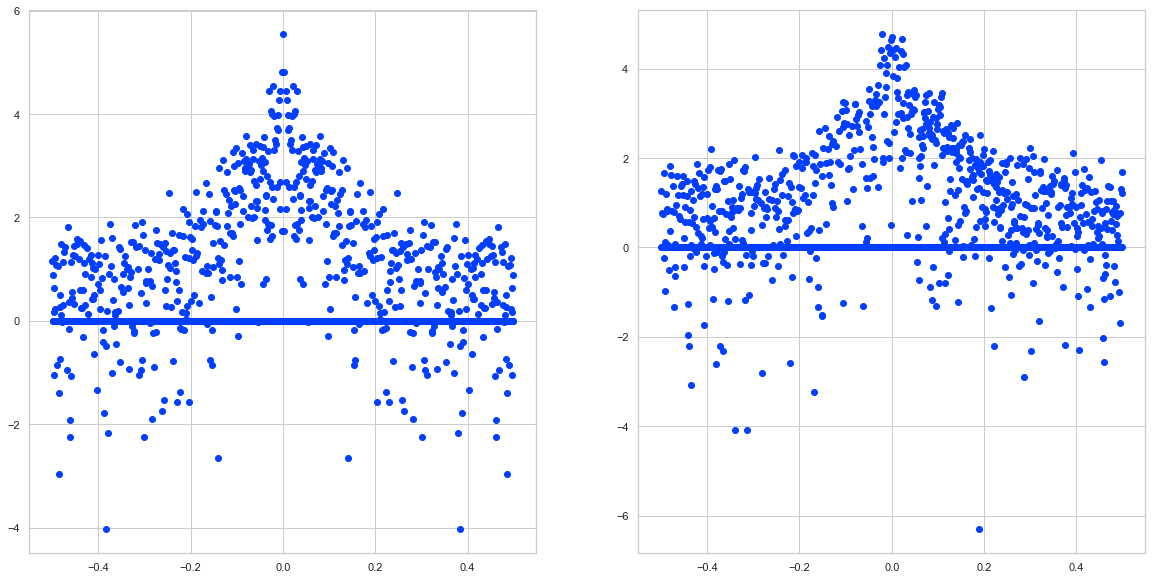

In [33]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(log1['Freq'], log1['Ampli'])
axs[1].scatter(log1i['Freq'], log1i['Ampli'])

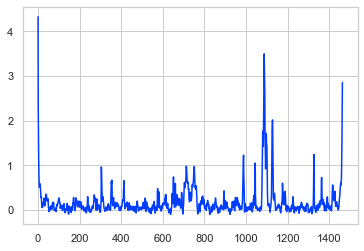

In [34]:
log1["Ampli"] = np.exp(log1["Ampli"])
log1i["Ampli"] = np.exp(log1i["Ampli"])
value = idft2(log1,log1i)
plt.plot(value)

In [35]:
distance.euclidean(signal_1["Value"],value)

13.606090752746866

## Cepstrum

In [36]:
duration = signal_1.shape[0]
fs = 1.0
samples = int(fs*duration)
t = np.arange(samples) / fs
ceps, _ = complex_cepstrum(signal_1['Value'])
print(ceps)

[  1.85366973 -13.75789601 -27.26838433 ...   2.98246573  27.77129429
  14.86999933]


174.0


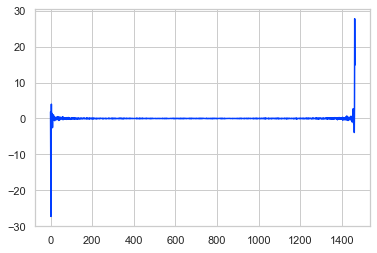

In [37]:
print(_)
plt.plot(t, ceps)

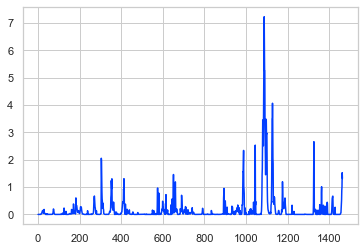

In [40]:
incep = inverse_complex_cepstrum(ceps, np.array(174.0))    # inverse ceps
plt.plot(signal_1['Time'], incep)

In [41]:
distance.euclidean(signal_1["Value"],incep)

2.6604432156806958e-11

# GMM of All

## GMM on Time Series

In [42]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 100)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [43]:
ts = GMM_fit(signal_1)
print(ts, '\n')
print('WEIGHTS -', ts.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', ts.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=16) 

WEIGHTS - [0.06633684 0.0574066  0.01696967 0.04085725 0.07983569 0.01584484
 0.14016402 0.02665801 0.12755883 0.02965835 0.08464044 0.01285516
 0.1375201  0.03475539 0.10792517 0.02101364] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[6.78987378e+02 1.17081241e-01]
 [7.29836343e+01 7.31950480e-04]
 [1.40140311e+03 7.87290661e-01]
 [3.70893375e+02 1.68909047e-01]
 [1.05290990e+03 2.40317604e-01]
 [6.26596711e+02 5.98182738e-01]
 [8.45112630e+02 5.02132710e-04]
 [1.37129955e+03 1.08935794e-01]
 [1.30158842e+03 1.15512351e-04]
 [1.86207787e+02 1.72054879e-01]
 [2.30018709e+02 2.37677564e-02]
 [4.10660071e+01 1.08641658e-01]
 [4.22936074e+02 1.14034065e-03]
 [1.08243239e+03 2.51796078e+00]
 [9.26669422e+02 1.97665805e-02]
 [3.32769996e+02 7.57311260e-01]] 



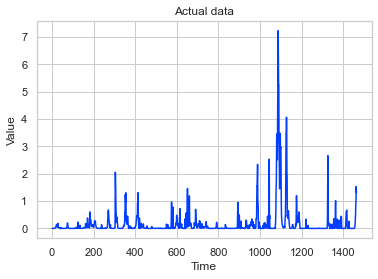

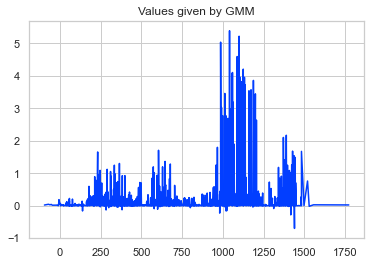

In [46]:
z,_ = ts.sample(1464)
plt.title('Actual data')
sns.lineplot(signal_1['Time'], signal_1['Value'])
plt.show()
plt.title('Values given by GMM')
sns.lineplot(z[:,0],z[:,1])
plt.show()

In [47]:
distance.euclidean(signal_1["Value"], z[:, 1])

32.953603997375474

## GMM on Real and Img Freq

In [48]:
freq_ampli1,freq_ampli1i = freq(signal_1)

In [49]:
fr = GMM_fit(freq_ampli1)                        # GMM on real part of FFT data
fi = GMM_fit(freq_ampli1i)                      # GMM on imaginary part of FFT data

In [51]:
print(fr, '\n')
print('WEIGHTS -', fr.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',fr.means_, '\n')

GaussianMixture(covariance_type='tied', n_components=28) 

WEIGHTS - [0.22171966 0.00136612 0.00537937 0.0137745  0.01650905 0.00068306
 0.04010647 0.00136612 0.00136612 0.01209158 0.04220747 0.00409836
 0.00523166 0.04639133 0.05145811 0.11089815 0.00546448 0.00136612
 0.00418347 0.01632485 0.01146974 0.2172835  0.00479951 0.02215143
 0.03748289 0.01350628 0.06783869 0.0234819 ] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 3.63869435e-01 -8.57136135e-02]
 [-7.37101658e-10  7.20036417e+01]
 [-8.40621766e-06 -6.53646615e+01]
 [ 9.68014510e-04  2.06720123e+01]
 [-3.86513507e-02 -1.33923813e+01]
 [ 0.00000000e+00  2.54664409e+02]
 [-7.11705246e-02  6.67950174e+00]
 [ 0.00000000e+00 -1.31789794e+02]
 [ 0.00000000e+00  1.24200533e+02]
 [-1.53488012e-03 -2.46872384e+01]
 [-1.97163940e-01 -6.36963327e+00]
 [ 2.54268176e-10  8.81566694e+01]
 [ 3.04571531e-04  3.82983230e+01]
 [ 1.83352149e-01  4.23806870e+00]
 [ 1.71391644e-01 -1.62339124e+00]
 [-3.12581765e-01  1.87403820e+00]
 [ 1.40412827

In [52]:
print(fi, '\n')
print('WEIGHTS -', fi.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',fi.means_, '\n')

GaussianMixture(n_components=7) 

WEIGHTS - [0.32470866 0.0150874  0.01525113 0.16573601 0.10910255 0.17527265
 0.19484159] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-3.32806464e-01 -3.63934669e-01]
 [ 2.34987558e-03  7.31776620e+01]
 [-2.45155388e-03 -7.27277677e+01]
 [-8.09044777e-02 -8.46515100e+00]
 [ 6.03866131e-02  1.34096645e+01]
 [ 2.77451991e-01 -1.36378805e+00]
 [ 3.38306888e-01  1.55141273e+00]] 



In [53]:
z1,_ = fr.sample(freq_ampli1.shape[0])
z1i,_ = fi.sample(freq_ampli1i.shape[0])

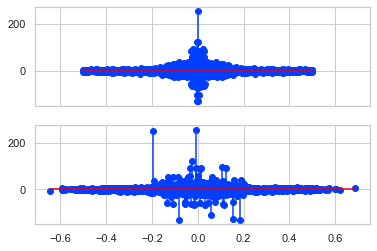

In [54]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].stem(freq_ampli1['Freq'], freq_ampli1['Ampli'])
#plt.show()
ax[1].stem(z1[:, 0], z1[:, 1])
plt.show()

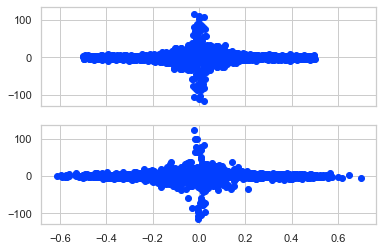

In [55]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli1i['Freq'], freq_ampli1i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

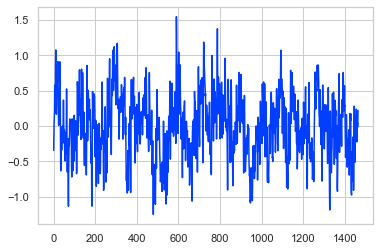

In [56]:
fr_d = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])
fi_d = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])
value = idft2(fr_d,fi_d)
plt.plot(value)

In [57]:
distance.euclidean(signal_1["Value"], value)

27.89258277081063

## GMM on Log-Freq

In [58]:
lr = GMM_fit(log1)                        # GMM on real part of FFT data
li = GMM_fit(log1i)

In [59]:
print(lr, '\n')
print('WEIGHTS -', lr.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',lr.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=12) 

WEIGHTS - [0.27796803 0.00546963 0.0284647  0.00068306 0.00545886 0.04051342
 0.28158656 0.00136612 0.01383503 0.007489   0.28742509 0.0497405 ] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.57601972e-01  1.00000023e+00]
 [-6.93235725e-18  8.40930038e+01]
 [ 1.70078306e-07  2.01363062e+01]
 [ 0.00000000e+00  2.54664409e+02]
 [-7.48609639e-15  5.47446140e+01]
 [-7.72391987e-06  1.16851912e+01]
 [-1.24257315e-03  2.20750632e+00]
 [ 0.00000000e+00  1.24200533e+02]
 [-9.23990077e-09  2.83171553e+01]
 [ 4.66209034e-10  3.64018094e+01]
 [-2.49125451e-01  9.99998613e-01]
 [ 1.70131654e-04  6.58674929e+00]] 



In [60]:
print(li, '\n')
print('WEIGHTS -', li.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',li.means_, '\n')

GaussianMixture(n_components=6) 

WEIGHTS - [0.50118861 0.11217983 0.01353105 0.19964706 0.17144109 0.00201236] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-2.37008015e-02  9.99998258e-01]
 [ 3.79789443e-02  1.48958660e+01]
 [ 1.93820136e-03  6.63543826e+01]
 [ 3.05208805e-01  2.69872625e+00]
 [-3.13138740e-01  2.81909882e+00]
 [ 5.71356500e-04  1.11779246e+02]] 



In [61]:
z2,_ = lr.sample(log1.shape[0])
z2i,_ = li.sample(log1i.shape[0])

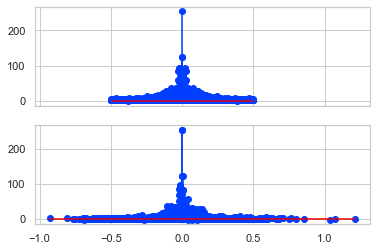

In [62]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].stem(log1['Freq'], log1['Ampli'])
#plt.show()
ax[1].stem(z2[:, 0], z2[:, 1])
plt.show()

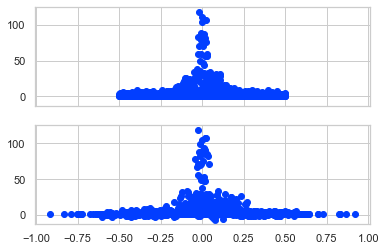

In [63]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(log1i['Freq'], log1i['Ampli'])
#plt.show()
ax[1].scatter(z2i[:, 0], z2i[:, 1])
plt.show()

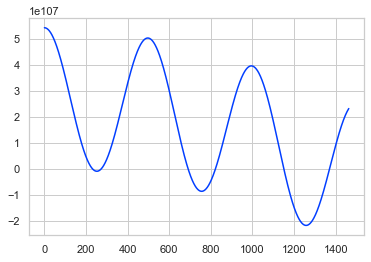

In [64]:
lr_d = pd.DataFrame(zip(z2[:,0],np.exp(z2[:,1])),columns=['Freq','Ampli'])
li_d = pd.DataFrame(zip(z2i[:,0],np.exp(z2i[:,1])),columns=['Freq','Ampli'])
value = idft2(lr_d,li_d)
plt.plot(value)

In [65]:
distance.euclidean(signal_1["Value"],value)

1.0235751192486353e+109

## GMM on Cepstrum

In [66]:
c1 = np.array(ceps).reshape(-1, 1)
c = GMM_fit(c1)

In [67]:
print(c, '\n')
print('WEIGHTS -', c.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', c.means_, '\n')

GaussianMixture(n_components=7) 

WEIGHTS - [8.08268944e-01 6.83060109e-04 6.83060109e-04 6.83060109e-04
 6.83060109e-04 1.94630867e-02 1.69535729e-01] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 3.44247012e-04]
 [ 1.48699993e+01]
 [-2.72683843e+01]
 [-1.37578960e+01]
 [ 2.77712943e+01]
 [ 1.17372866e-01]
 [ 6.97687593e-04]] 



In [68]:
z3,_ = c.sample(c1.shape[0])

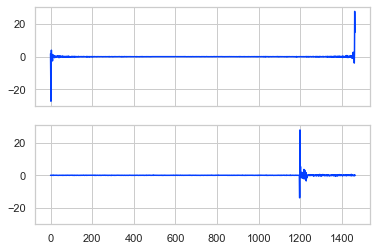

In [69]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].plot(t, ceps)
#plt.show()
ax[1].plot(t, z3.flatten())
plt.show()

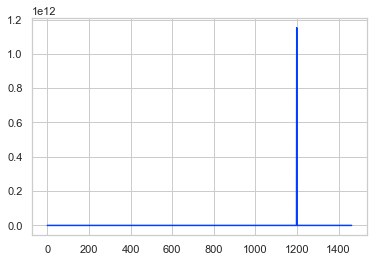

In [70]:
gmm_incep = inverse_complex_cepstrum(z3, np.array(1.0))    # inverse ceps
plt.plot(signal_1['Time'], gmm_incep)

In [71]:
distance.euclidean(signal_1['Value'], gmm_incep)

1152107187979.1997